# [Boosters] Raiffeisen Data Cup. Baseline
Общий подход:
- Добавляем к каждой транзакции столбец: is_work (если транзакция находится в пределах 0.02 от дома клиента)
- Добавляем к каждой транзакции столбец: is_home (если транзакция находится в пределах 0.02 от работы клиента)
- Обучаем классификатор предсказывающий вероятность (is_home == 1) для транзакции
- Обучаем классификатор предсказывающий вероятность (is_work == 1) для транзакции

Точность определения местоположения:
- для классификатора is_home: ~3x%
- для классификатора is_work: ~2x%
- общая оценка на Public Leaderboard: ???

Примечание
* Требуется Python версии 3.5
* Требуется библиотека xgboost (для обучения использовалась xgboost версии 0.7.post3)
* Требуются файлы: test_set.csv, train_set.csv в одном каталоге с данным скриптом
* Требования к памяти: должно работать с 2Гб свободного RAM
* Время работы: ~3 минуты (тестировалось на процессоре Intel Core i7-4770)

In [1]:
%load_ext autoreload
%autoreload 2

import sys
MODULES_PATH = '../code/'
if MODULES_PATH not in sys.path:
    sys.path.append(MODULES_PATH)
import mfuncs
    
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
pd.options.display.max_columns = 1000

import lightgbm as lgb


from sklearn.neighbors import NearestNeighbors
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Определим типы колонок для экономии памяти
dtypes = {
    'transaction_date': str,
    'atm_address': str,
    'country': str,
    'city': str,
    'amount': np.float32,
    'currency': np.float32,
    'mcc': str,
    'customer_id': str,
    'pos_address': str,
    'atm_address': str,
    'pos_adress_lat': np.float32,
    'pos_adress_lon': np.float32,
    'pos_address_lat': np.float32,
    'pos_address_lon': np.float32,
    'atm_address_lat': np.float32,
    'atm_address_lon': np.float32,
    'home_add_lat': np.float32,
    'home_add_lon': np.float32,
    'work_add_lat': np.float32,
    'work_add_lon': np.float32,
}

# для экономии памяти будем загружать только часть атрибутов транзакций
usecols_train = ['customer_id','transaction_date','amount','country', 'city', 'currency', 'mcc', 'pos_adress_lat', 'pos_adress_lon', 'atm_address_lat', 'atm_address_lon','home_add_lat','home_add_lon','work_add_lat','work_add_lon']
usecols_test = ['customer_id','transaction_date','amount','country', 'city', 'currency', 'mcc', 'pos_address_lat', 'pos_address_lon', 'atm_address_lat', 'atm_address_lon']

## Читаем train_set, test_set, соединяем в один датасет

In [3]:
dtypes = {
    'transaction_date': str,
    'atm_address': str,
    'country': str,
    'city': str,
    'amount': np.float32,
    'currency': np.float32,
    'mcc': str,
    'customer_id': str,
    'pos_address': str,
    'atm_address': str,
    'pos_adress_lat': np.float32,
    'pos_adress_lon': np.float32,
    'pos_address_lat': np.float32,
    'pos_address_lon': np.float32,
    'atm_address_lat': np.float32,
    'atm_address_lon': np.float32,
    'home_add_lat': np.float32,
    'home_add_lon': np.float32,
    'work_add_lat': np.float32,
    'work_add_lon': np.float32,
}

rnm = {
    'atm_address_lat': 'atm_lat',
    'atm_address_lon': 'atm_lon',
    'pos_adress_lat': 'pos_lat',
    'pos_adress_lon': 'pos_lon',
    'pos_address_lat': 'pos_lat',
    'pos_address_lon': 'pos_lon',
    'home_add_lat': 'home_lat',
    'home_add_lon': 'home_lon',
    'work_add_lat': 'work_lat',
    'work_add_lon': 'work_lon',
}

In [5]:
df_train = pd.read_csv('../data/train_set.csv', dtype=dtypes)
df_test = pd.read_csv('../data/test_set.csv', dtype=dtypes)

df_train.rename(columns=rnm, inplace=True)
df_test.rename(columns=rnm, inplace=True)

In [6]:
# удалим чувак с множественными адресами
print(df_train.shape)
gb = df_train.groupby('customer_id')['work_lat'].agg('nunique') 
cid_incorrect = gb[gb == 2].index
df_train = df_train[~df_train.customer_id.isin(cid_incorrect.values)]
print(df_train.shape)
gb = df_train.groupby('customer_id')['home_lat'].agg('nunique') 
cid_incorrect = gb[gb == 2].index
df_train = df_train[~df_train.customer_id.isin(cid_incorrect.values)]
print(df_train.shape)

(1224734, 18)
(1207958, 18)
(1142653, 18)


In [7]:
# соединяем test/train в одном DataFrame
df_train['is_train'] = np.int32(1)
df_test['is_train'] = np.int32(0)
df_all = pd.concat([df_train, df_test])

del df_train, df_test

### Обрабатываем дату транзакции и категориальные признаки

In [8]:
df_all['currency'] = df_all['currency'].fillna(-1).astype(np.int32)
df_all['mcc'] = df_all['mcc'].apply(lambda x: int(x.replace(',', ''))).astype(np.int32)
df_all['city'] = df_all['city'].factorize()[0].astype(np.int32)
df_all['country'] = df_all['country'].factorize()[0].astype(np.int32)

# удаляем транзакции без даты
df_all = df_all[~df_all['transaction_date'].isnull()]
df_all['transaction_date'] =  pd.to_datetime(df_all['transaction_date'], format='%Y-%m-%d')

### Фичи для даты

In [9]:
df_all['month'] = df_all.transaction_date.dt.month
df_all['day'] = df_all.transaction_date.dt.day
df_all['dayofyear'] = df_all.transaction_date.dt.dayofyear
df_all['dayofweek'] = df_all.transaction_date.dt.dayofweek

### Приводим адрес транзакции для pos и atm-транзакций к единообразному виду
Просто объединяем в одну колонку и добавляем фичу - это атм или пос

In [10]:
dfs = []
for cid in tqdm(df_all.customer_id.unique()):
    df_an = df_all[df_all.customer_id == cid]
    df_an = mfuncs.add_dist_to_neighbours(df_an)
    dfs.append(df_an)

100%|██████████| 19642/19642 [2:17:07<00:00,  6.49it/s]  


In [11]:
df_knn = pd.concat(dfs)
df_knn.head()

In [13]:
df_knn['pos2pos_1', 'pos2pos_2', 'atm2pos_1', 'atm2pos_2', 'pos2atm_1',
       'pos2atm_2', 'pos2atm_1', 'pos2atm_2']

Index(['amount', 'atm_address', 'atm_lat', 'atm_lon', 'city', 'country',
       'currency', 'customer_id', 'home_lat', 'home_lon', 'is_train', 'mcc',
       'pos_address', 'pos_lat', 'pos_lon', 'terminal_id', 'transaction_date',
       'work_lat', 'work_lon', 'month', 'day', 'dayofyear', 'dayofweek',
       'pos2pos_1', 'pos2pos_2', 'atm2pos_1', 'atm2pos_2', 'pos2atm_1',
       'pos2atm_2', 'pos2atm_1', 'pos2atm_2'],
      dtype='object')

In [14]:
df_knn.to_csv('../data/df_knn.csv', index=None)

In [43]:
df_all = df_knn.copy()

In [44]:
df_all['is_atm'] = (~df_all['atm_lat'].isnull()).astype(np.int8)
df_all['is_pos'] = (~df_all['pos_lat'].isnull()).astype(np.int8)

df_all['add_lat'] = df_all['atm_lat'].fillna(0) + df_all['pos_lat'].fillna(0)
df_all['add_lon'] = df_all['atm_lon'].fillna(0) + df_all['pos_lon'].fillna(0)

df_all.drop(['atm_lat','atm_lon','pos_lat','pos_lon'], axis=1, inplace=True)

df_all = df_all[~((df_all['add_lon'] == 0) & (df_all['add_lon'] == 0))]

### Генерируем признаки is_home, is_work
TODO: удалить чуваков у которых несколько домов

In [45]:
lat = df_all['home_lat'] - df_all['add_lat']
lon = df_all['home_lon'] - df_all['add_lon']

df_all['is_home'] = (np.sqrt((lat ** 2) + (lon ** 2)) <= 0.02).astype(np.int8)
df_all['has_home'] = (~df_all['home_lon'].isnull()).astype(np.int8)

lat = df_all['work_lat'] - df_all['add_lat']
lon = df_all['work_lon'] - df_all['add_lon']
df_all['is_work'] = (np.sqrt((lat ** 2) + (lon ** 2)) <= 0.02).astype(np.int8)
df_all['has_work'] = (~df_all['work_lon'].isnull()).astype(np.int8)

df_all.drop(['work_lat','work_lon','home_lat','home_lon'], axis=1, inplace=True)

### Генерируем категориальный признак для адреса

In [46]:
df_all['address'] = df_all['add_lat'].apply(lambda x: "%.02f" % x) + ';' + df_all['add_lon'].apply(lambda x: "%.02f" % x)
df_all['address'] = df_all['address'].factorize()[0].astype(np.int32)

### Генерируем несколько абонентских фич

In [47]:
# количество транзакций каждого клиента
df_all = df_all.merge(df_all.groupby('customer_id')['amount'].count().reset_index(name='cid_trans_count'), how='left')
df_all['cid_trans_count'] = df_all['cid_trans_count'].astype(np.int32)

df_all = df_all.merge(df_all.groupby(['customer_id','address'])['amount'].count().reset_index(name='cid_add_trans_count'), 
                      how='left')
df_all['cid_add_trans_count'] = df_all['cid_add_trans_count'].astype(np.int32)

# какая часть транзакций клиента приходится на данный адрес
# TODO: БОЛЬШЕ ТАКИХ ФИЧ
df_all['ratio1'] = df_all['cid_add_trans_count'] / df_all['cid_trans_count']

## Мои фичи

In [53]:
df_gb[['amount', 'add_lat', 'add_lon']].agg(['mean', 'max', 'min'])

ValueError: cannot reindex from a duplicate axis

In [55]:
df_all[['customer_id','amount', 'add_lat', 'add_lon']]

,customer_id,amount,add_lat,add_lon
0,0dc0137d280a2a82d2dc89282450ff1b,2.884034,59.844074,30.179153
1,0dc0137d280a2a82d2dc89282450ff1b,2.775633,59.844074,30.179153
2,0dc0137d280a2a82d2dc89282450ff1b,3.708368,59.858200,30.229023
3,0dc0137d280a2a82d2dc89282450ff1b,2.787498,59.844074,30.179153
4,0dc0137d280a2a82d2dc89282450ff1b,2.892510,59.844074,30.179153
5,0dc0137d280a2a82d2dc89282450ff1b,2.909018,59.844074,30.179153
6,0dc0137d280a2a82d2dc89282450ff1b,2.801228,59.844074,30.179153
7,0dc0137d280a2a82d2dc89282450ff1b,2.838200,59.844074,30.179153
8,0dc0137d280a2a82d2dc89282450ff1b,3.264740,59.844074,30.179153
9,0dc0137d280a2a82d2dc89282450ff1b,3.118792,59.844074,30.179153


In [64]:
df_gb['amount', 'add_lat', 'add_lon'].agg(['mean', 'max', 'min'])

ValueError: cannot reindex from a duplicate axis

In [70]:
df_all.reset_index(inplace=True, drop=True)

In [75]:
df_all[['customer_id','amount', 'add_lat', 'add_lon']].groupby('customer_id').agg('max')

,amount,add_lat,add_lon
customer_id,,,
0001f322716470bf9bfc1708f06f00fc,4.614833,56.251347,43.446255
00021683ccb416637fe9a4cd35e4606e,5.178286,55.449772,84.168541
0002d0f8a642272b41c292c12ab6e602,3.617783,59.829090,50.173374
0004d182d9fede3ba2534b2d5e5ad27e,4.209749,43.597000,39.975124
0007297d86e14bd68bd87b1dbdefe302,4.696914,59.949146,38.980770
0008c2445518c9392cb356c5c3db3392,4.471992,53.198917,46.748531
000b373cc4969c0be8e0933c08da67e1,3.492366,59.934464,49.919624
000b709c6c6fb1e8efcfd95e57c2a9de,4.319009,56.512737,86.172333
000c589e94c95984721de4b2bfb9ee4e,3.154039,55.725166,37.425613


In [76]:
# добавим признаки после групбая
df_gb = df_all[['customer_id','amount', 'add_lat', 'add_lon']].groupby('customer_id')
coord_stat_df = df_gb.agg(['mean', 'max', 'min'])
coord_stat_df['transactions_per_user'] = df_gb.agg('size')
coord_stat_df.columns = ['_'.join(col).strip() for col in coord_stat_df.columns.values]
coord_stat_df.reset_index(inplace=True)
df_all = pd.merge(df_all, coord_stat_df, on='customer_id', how='left')

In [77]:
cols = ['add_lat', 'add_lon']
types = ['min', 'max', 'mean']
for c in cols:
    for t in types:
        df_all['{}_ratio_{}'.format(c, t)] = np.abs(df_all[c] / df_all['{}_{}'.format(c, t)])

In [78]:
df_all = pd.concat([df_all, pd.get_dummies(df_all['mcc'], prefix='mcc')], axis=1)
del df_all['mcc']

# LightGBM

In [92]:
df_all = df_all.loc[:,~df_all.columns.duplicated()]

In [111]:
from sklearn.model_selection import train_test_split

ys = ['is_home', 'is_work']
drop_cols = ['atm_address', 'customer_id', 'pos_address', 'terminal_id', 'transaction_date', 
             'is_home' ,'has_home', 'is_work', 'has_work', 'is_train']

drop_cols += ['pred:is_home', 'pred:is_work']
y_cols = ['is_home', 'is_work']
usecols = df_all.drop(drop_cols, 1, errors='ignore').columns

In [112]:
params = {
    'objective': 'binary',
    'num_leaves': 63,
    'learning_rate': 0.01,
    'metric' : 'binary_logloss',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'num_threads': 12,
    'verbose': 0,
}

model = {}

In [113]:
y_col = 'is_home'

cust_train = df_all[df_all['is_train']==1].groupby('customer_id')[y_col.replace('is_','has_')].max()
cust_train = cust_train[cust_train > 0].index

cust_train, cust_valid = train_test_split(cust_train, test_size=0.2, shuffle=True, random_state=111)

df_train = pd.DataFrame(cust_train, columns=['customer_id']).merge(df_all, how='left')
df_valid = pd.DataFrame(cust_valid, columns=['customer_id']).merge(df_all, how='left')

lgb_train = lgb.Dataset(df_train[usecols], df_train[y_col])
lgb_valid = lgb.Dataset(df_valid[usecols], df_valid[y_col])

gbm_h = lgb.train(params,
                lgb_train,
                valid_sets=[lgb_valid],
                num_boost_round=2000,
                verbose_eval=30,
                early_stopping_rounds=300)

model[y_col] = gbm_h

Training until validation scores don't improve for 300 rounds.
[30]	valid_0's binary_logloss: 0.60709
[60]	valid_0's binary_logloss: 0.55481
[90]	valid_0's binary_logloss: 0.52188
[120]	valid_0's binary_logloss: 0.500737
[150]	valid_0's binary_logloss: 0.486256
[180]	valid_0's binary_logloss: 0.476052
[210]	valid_0's binary_logloss: 0.46878
[240]	valid_0's binary_logloss: 0.463383
[270]	valid_0's binary_logloss: 0.458828
[300]	valid_0's binary_logloss: 0.455549
[330]	valid_0's binary_logloss: 0.452839
[360]	valid_0's binary_logloss: 0.450904
[390]	valid_0's binary_logloss: 0.448986
[420]	valid_0's binary_logloss: 0.447638
[450]	valid_0's binary_logloss: 0.446429
[480]	valid_0's binary_logloss: 0.445285
[510]	valid_0's binary_logloss: 0.444496
[540]	valid_0's binary_logloss: 0.443656
[570]	valid_0's binary_logloss: 0.443121
[600]	valid_0's binary_logloss: 0.44271
[630]	valid_0's binary_logloss: 0.442535
[660]	valid_0's binary_logloss: 0.442225
[690]	valid_0's binary_logloss: 0.441854
[7

In [114]:
y_col = 'is_work'

cust_train = df_all[df_all['is_train']==1].groupby('customer_id')[y_col.replace('is_','has_')].max()
cust_train = cust_train[cust_train > 0].index

cust_train, cust_valid = train_test_split(cust_train, test_size=0.2, shuffle=True, random_state=111)



df_train = pd.DataFrame(cust_train, columns=['customer_id']).merge(df_all, how='left')
df_valid = pd.DataFrame(cust_valid, columns=['customer_id']).merge(df_all, how='left')

lgb_train = lgb.Dataset(df_train[usecols], df_train[y_col])
lgb_valid = lgb.Dataset(df_valid[usecols], df_valid[y_col])

gbm_w = lgb.train(params,
                lgb_train,
                valid_sets=[lgb_valid],
                num_boost_round=2000,
                verbose_eval=30,
                early_stopping_rounds=300)

model[y_col] = gbm_w

Training until validation scores don't improve for 300 rounds.
[30]	valid_0's binary_logloss: 0.577203
[60]	valid_0's binary_logloss: 0.505615
[90]	valid_0's binary_logloss: 0.46027
[120]	valid_0's binary_logloss: 0.429884
[150]	valid_0's binary_logloss: 0.409737
[180]	valid_0's binary_logloss: 0.395657
[210]	valid_0's binary_logloss: 0.385574
[240]	valid_0's binary_logloss: 0.378012
[270]	valid_0's binary_logloss: 0.372507
[300]	valid_0's binary_logloss: 0.367728
[330]	valid_0's binary_logloss: 0.364101
[360]	valid_0's binary_logloss: 0.36112
[390]	valid_0's binary_logloss: 0.359536
[420]	valid_0's binary_logloss: 0.357894
[450]	valid_0's binary_logloss: 0.35652
[480]	valid_0's binary_logloss: 0.3556
[510]	valid_0's binary_logloss: 0.354502
[540]	valid_0's binary_logloss: 0.353899
[570]	valid_0's binary_logloss: 0.353522
[600]	valid_0's binary_logloss: 0.353235
[630]	valid_0's binary_logloss: 0.353279
[660]	valid_0's binary_logloss: 0.353185
[690]	valid_0's binary_logloss: 0.353026
[7

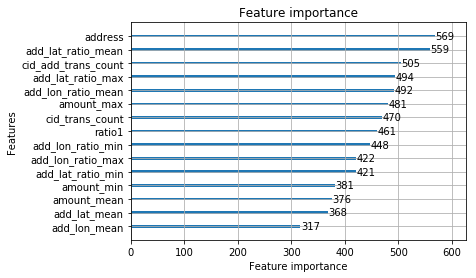

In [110]:
lgb.plot_importance(gbm_w, max_num_features=15)

In [115]:
def _best(x):
    ret = None
    for col in ys:
        pred = ('pred:%s' % col)
        if pred in x:
            i = (x[pred].idxmax())
            cols = [pred, 'add_lat', 'add_lon']
            if col in x:
                cols.append(col)
            tmp = x.loc[i,cols]
            tmp.rename({
                'add_lat':'%s:add_lat' % col,
                'add_lon':'%s:add_lon' % col,
            }, inplace = True)
            if ret is None:
                ret = tmp
            else:
                ret = pd.concat([ret, tmp])
    return ret

def predict_proba(dt, ys=['is_home', 'is_work']):
    for col in ys:
        pred = ('pred:%s' % col)
        dt[pred] = model[col].predict(dt[usecols])
    return dt.groupby('customer_id').apply(_best).reset_index()

def score(dt, ys=['is_home', 'is_work']):
    dt_ret = predict_proba(dt, ys)
    mean = 0.0
    for col in ys:
        col_mean = dt_ret[col].mean()
        mean += col_mean
    if len(ys) == 2:
        mean = mean / len(ys)
    return mean

In [ ]:
print ("Train accuracy:", score(df_train, ys=['is_home']))
print ("Test accuracy:", score(df_valid, ys=['is_home']))

print ("Train accuracy:", score(df_train, ys=['is_work']))
print ("Test accuracy:", score(df_valid, ys=['is_work']))

Train accuracy: 0.5152524993591386
Test accuracy: 0.5204918032786885


# Predict

In [ ]:
cust_test = df_all[df_all['is_train'] == 0]['customer_id'].unique()
df_test = pd.DataFrame(cust_test, columns = ['customer_id']).merge(df_all, how = 'left')
df_test = predict_proba(df_test)
df_test.rename(columns = {
        'customer_id':'_ID_',
        'is_home:add_lat': '_HOME_LAT_',
        'is_home:add_lon': '_HOME_LON_',
        'is_work:add_lat': '_WORK_LAT_',
        'is_work:add_lon': '_WORK_LON_'}, inplace = True)
df_test = df_test[['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_']]

df_test.head()

# Формируем submission-файл

In [ ]:
# Заполняем пропуски
df_ = pd.read_csv('../data/test_set.csv', dtype=dtypes, usecols=['customer_id'])
submission = pd.DataFrame(df_['customer_id'].unique(), columns=['_ID_'])

submission = submission.merge(df_test, how='left').fillna(0)
# Пишем файл submission
submission.to_csv('../submissions/base_2_47_32.csv', index=None)